In [ ]:
import torch
import lightning as L
from cheetah import ParticleBeam
from gpsr.modeling import GPSR, GPSRQuadScanLattice
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import QuadScanDataset
from cheetah.accelerator.screen import Screen


In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6  # reference momentum in eV/c

gt_beam = torch.load("../docs/examples/example_data/example_distributions/complex_beam.pt",weights_only=False)
gt_beam = ParticleBeam(gt_beam.particles, gt_beam.energy)

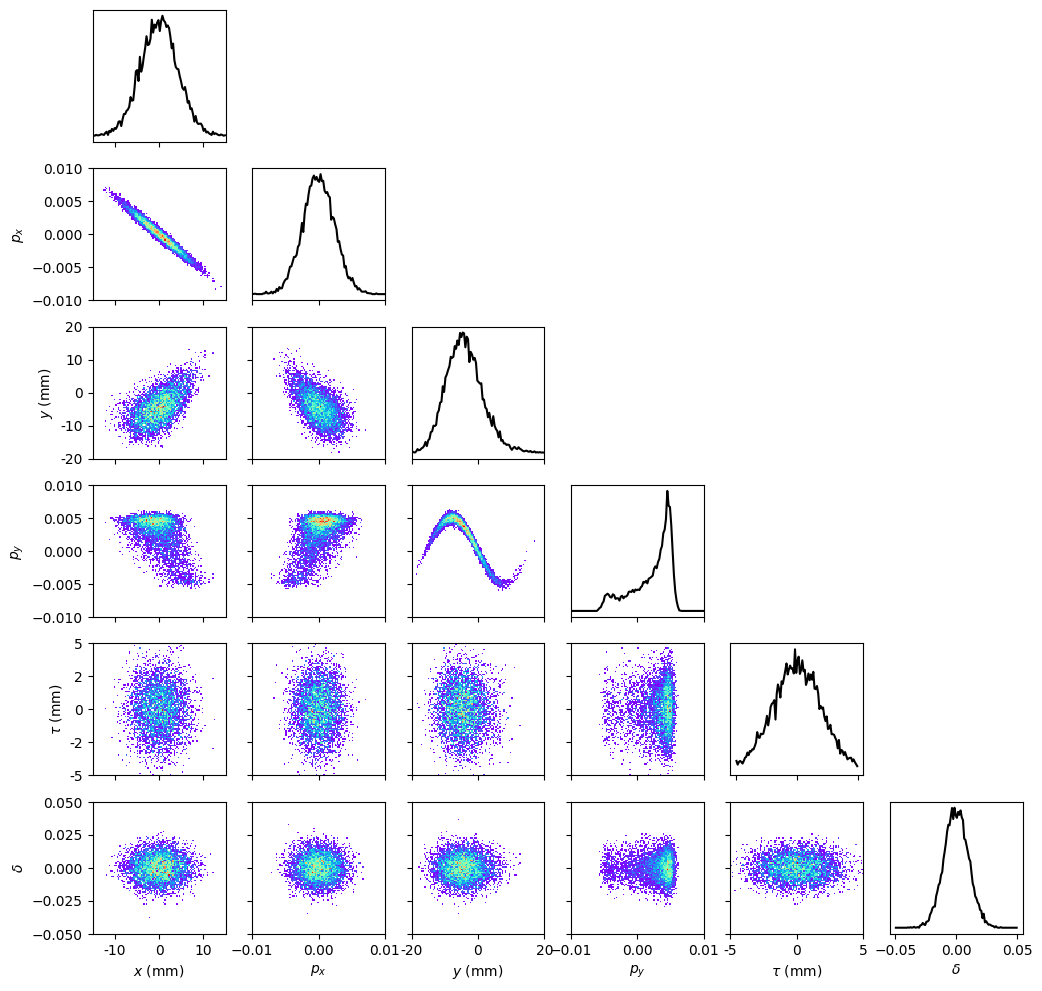

In [3]:
# plot synthetic ground truth beam projections
import numpy as np

lims = [
    [-15e-3, 15e-3],
    [-10e-3, 10e-3],
    [-20e-3, 20e-3],
    [-10e-3, 10e-3],
    [-5e-3, 5e-3],
    [-5e-2, 5e-2],
]
gt_beam.plot_distribution(bin_ranges=lims);

In [ ]:
# create diagnostic screen:
n_pixels = 100
pixel_size = torch.tensor(1e-3)

class COTRScreen(Screen):
    @property
    def reading(self) -> torch.Tensor:
        density = super().reading

        # calculate finite difference of the density
        dx = torch.diff(density, dim=-1, append=density[..., :, -1:])
        dy = torch.diff(density, dim=-2, append=density[..., -1:, :])
        return dx**2 + dy**2


screen = COTRScreen(
    resolution=(n_pixels, n_pixels),
    pixel_size=torch.tensor((pixel_size, pixel_size)),
    method="kde",
    kde_bandwidth=pixel_size*3,
    is_active=True,
)

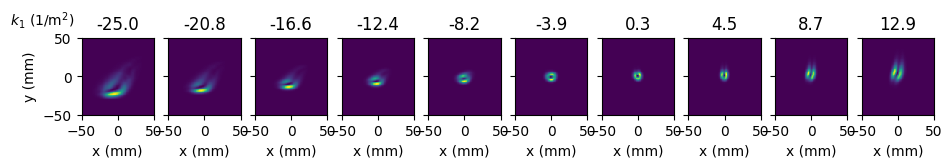

In [5]:
# create synthetic data
# get model
gpsr_lattice = GPSRQuadScanLattice(l_quad=0.1, l_drift=1.0, diagnostic=screen)

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks).unsqueeze(-1)
gpsr_lattice.set_lattice_parameters(ks)

# propagate beam and get images
images = gpsr_lattice.track_and_observe(gt_beam)[0]

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

train_images = images[::2]
test_images = images[1::2]

train_dset = QuadScanDataset(train_ks, train_images, screen=screen)
test_dset = QuadScanDataset(test_ks, test_images, screen=screen)

train_dset.plot_data();

In [6]:
train_dset.parameters.shape, train_dset.observations[0].shape

(torch.Size([10, 1]), torch.Size([10, 100, 100]))

In [7]:
#torch.save(train_dset, "../example_data/example_datasets/reconstruction_4D_train.dset")
#torch.save(test_dset, "../example_data/example_datasets/reconstruction_4D_test.dset")

In [8]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=20)

litgpsr = LitGPSR(gpsr_model, lr=1e-2)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)

In [26]:

trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rroussel\AppData\Local\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory .\lightning_logs\version_10\checkpoints exists and is not empty.

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
c:\Users\rroussel\AppData\Local\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [27]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

## Evaluate model on test samples to compare predictions

In [28]:
test_pred = gpsr_model(train_dset.parameters)[0].detach()
test_pred_dset = QuadScanDataset(train_dset.parameters, test_pred, screen=screen)
test_pred_dset.observations[0].shape

torch.Size([10, 100, 100])

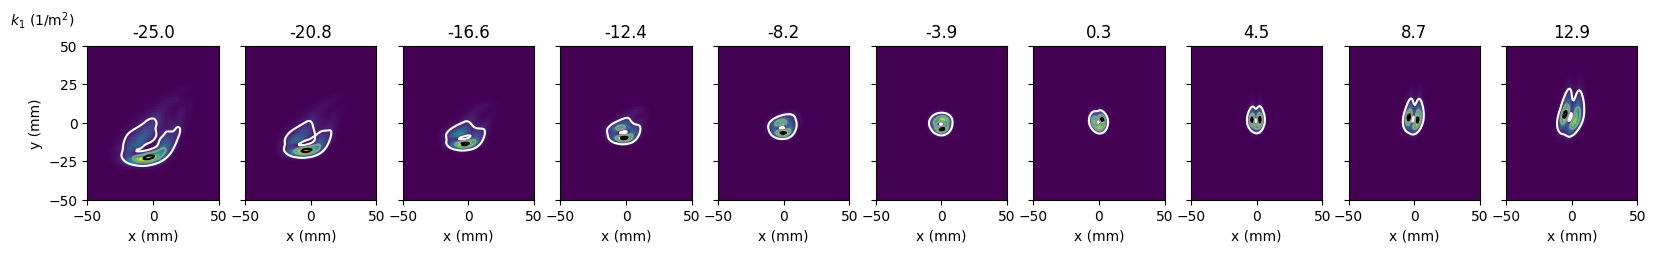

In [50]:
fig, ax = train_dset.plot_data(overlay_data=test_pred_dset)
#fig2, ax2 = test_pred_dset.plot_data()
#ax[0].set_ylim(-40,30)
#ax[0].set_xlim(-40,40)
fig.set_size_inches(20, 2)
fig.savefig("cotr_example_reconstruction.svg", bbox_inches="tight")

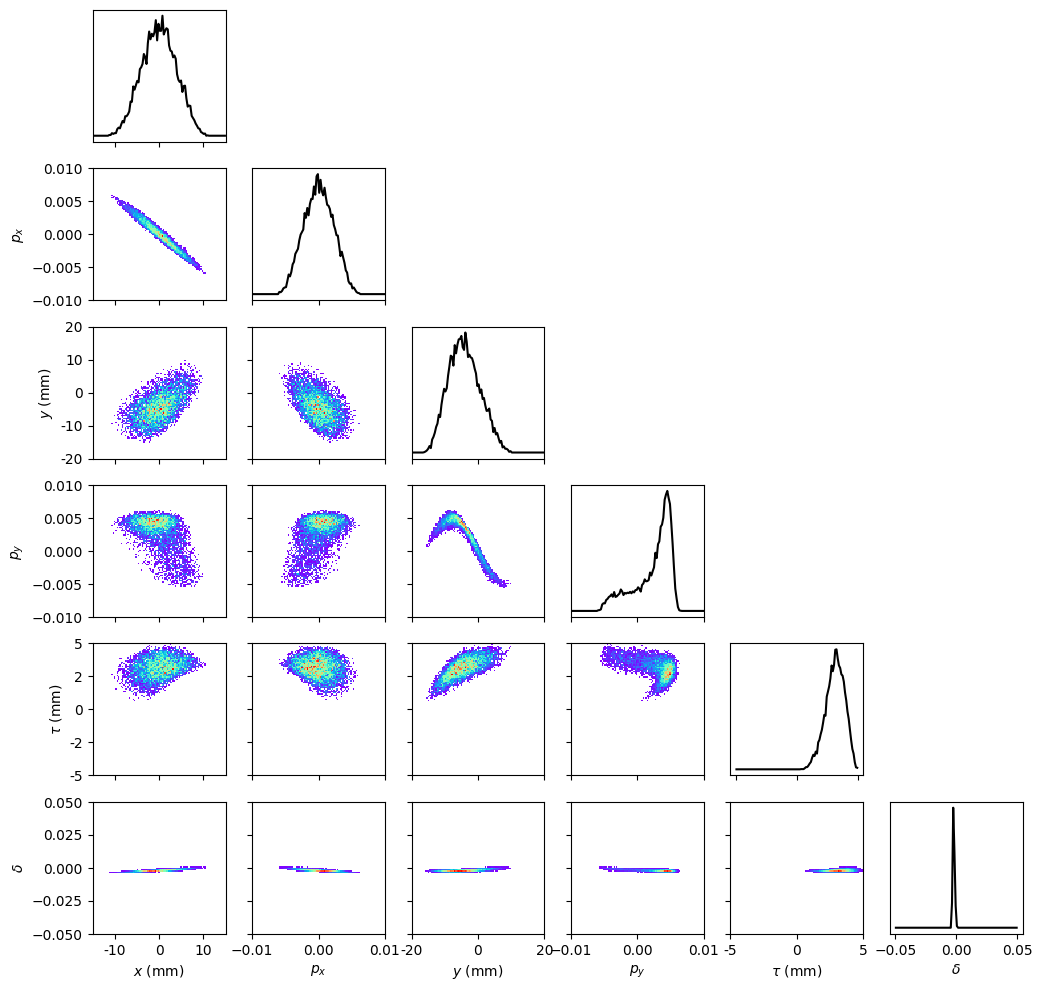

In [40]:
reconstructed_beam.plot_distribution(bin_ranges=lims);